# PART 3 :  N Step Double QLearning (n=4) by minazmeh and nagasita

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from collections import deque

Initial State:


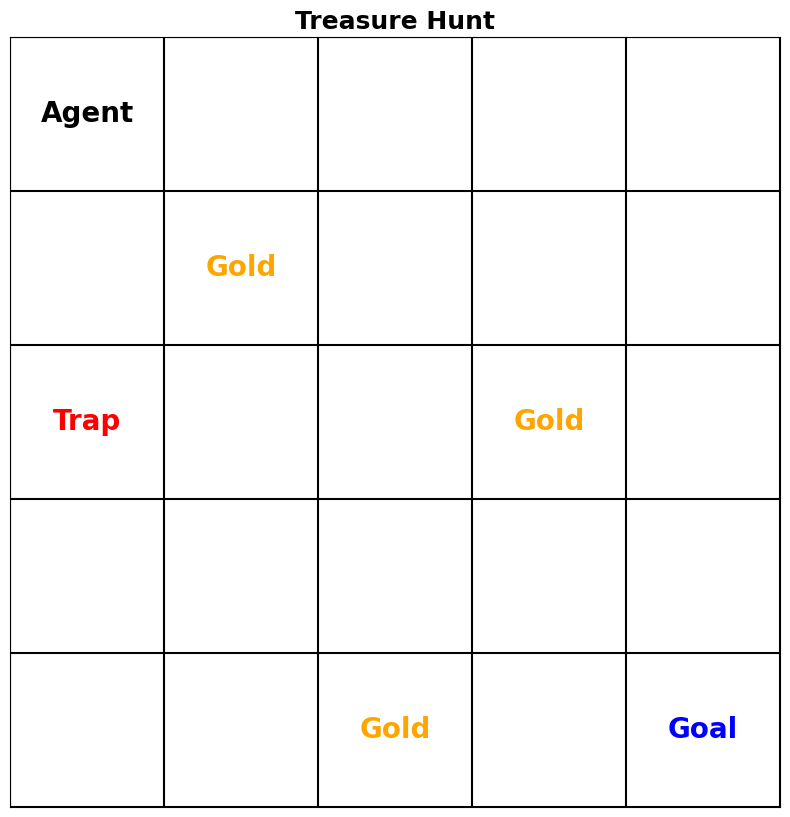

In [2]:
class TreasureHuntEnv:
    def __init__(self):
        self.action_space = ['Up', 'Down', 'Left', 'Right']
        self.state_space = [(x, y) for x in range(5) for y in range(5)]
        self.rewards = {
            (1, 1): 1,
            (4, 2): 3,
            (2, 3): 1,
            (2, 0): -1,
            (4, 4): 50 
        }
        self.current_state = (0, 0)

    def step(self, action): 
        x, y = self.current_state
        if action == 'Up':
            x = max(0, x - 1)
        elif action == 'Down':
            x = min(4, x + 1)
        elif action == 'Left':
            y = max(0, y - 1)
        elif action == 'Right':
            y = min(4, y + 1)

        self.current_state = (x, y)
        reward = self.rewards.get(self.current_state, 0)
        done = self.current_state == (4, 4)
        return self.current_state, reward, done

    def reset(self):
        self.current_state = (0, 0)
        return self.current_state
    
    def render(self):
        grid = np.zeros((5, 5)) 
        x, y = self.current_state 

        plt.figure(figsize=(10, 10))  
        for i in range(5):
            for j in range(5):
                if (i, j) == (4, 4):  
                    if (i, j) == self.current_state:
                        continue
                    plt.text(j + 0.5, 4 - i + 0.5, "Goal", ha='center', va='center',
                             color="blue", fontsize=20, fontweight='bold')
                    
                elif (i, j) in self.rewards:
                    if (i, j) == self.current_state: 
                        continue
                    if self.rewards[(i, j)] > 0:
                        plt.text(j + 0.5, 4 - i + 0.5, "Gold", ha='center', va='center',
                                 color="orange", fontsize=20, fontweight='bold')
                    elif self.rewards[(i, j)] < 0:
                        plt.text(j + 0.5, 4 - i + 0.5, "Trap", ha='center', va='center',
                                 color="red", fontsize=20, fontweight='bold')

        if self.current_state in self.rewards:
            if self.rewards[self.current_state] == 50:  
                agent_color = "blue"
                cell_color = "black"  
            elif self.rewards[self.current_state] > 0:  
                agent_color = "orange"
                cell_color = "black"  
            elif self.rewards[self.current_state] < 0:  
                agent_color = "red"
                cell_color = "black"
        else:
            agent_color = "black"  
            cell_color = None
        if cell_color:
            plt.gca().add_patch(plt.Rectangle((y, 4 - x), 1, 1, color=cell_color))

        plt.text(y + 0.5, 4 - x + 0.5, "Agent", ha='center', va='center',
                 color=agent_color, fontsize=20, fontweight='bold')

        for i in range(6):
            plt.axhline(i, color='black', linewidth=1.5)
            plt.axvline(i, color='black', linewidth=1.5)

        plt.xlim(0, 5)
        plt.ylim(0, 5)

        plt.gca().set_aspect('equal', adjustable='box') 
        plt.gca().set_xticks([]) 
        plt.gca().set_yticks([])
        plt.title("Treasure Hunt", fontsize=18, fontweight='bold')
        plt.show()

env = TreasureHuntEnv()
state = env.reset()
print("Initial State:")
env.render()

In [3]:
class NStepDoubleQLearningAgent:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, min_epsilon, n):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.n = n  # n-step parameter
        self.Q1 = {state: {action: 0 for action in env.action_space} for state in env.state_space}
        self.Q2 = {state: {action: 0 for action in env.action_space} for state in env.state_space}
        
        print("Initial Q1 Table:")
        for state, actions in self.Q1.items():
            print(f"{state}: {actions}")

        print("Initial Q2 Table:")
        for state, actions in self.Q2.items():
            print(f"{state}: {actions}")
        
    def epsilon_greedy(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.env.action_space)
        else:
            return max(self.env.action_space, key=lambda action: self.Q1[state][action] + self.Q2[state][action])

    def train(self, episodes):
        rewards_per_episode = []
        epsilon_values = []

        for episode in range(episodes):
            state = self.env.reset()
            done = False
            episode_memory = deque(maxlen=self.n)
            total_reward = 0
            t = 0 

            while not done:
                action = self.epsilon_greedy(state)
                next_state, reward, done = self.env.step(action)

                episode_memory.append((state, action, reward, next_state, done))

                total_reward += reward

                if len(episode_memory) >= self.n:
                    G = 0
                    for i in range(len(episode_memory)):
                        _, _, r, _, _ = episode_memory[i]
                        G += r * (self.gamma ** i)

                    state_n, action_n, _, next_state_n, done_n = episode_memory[-1]

                    if random.random() < 0.5:
                        best_next_action = max(self.Q1[next_state_n], key=self.Q1[next_state_n].get)
                        td_target = G + self.gamma ** self.n * self.Q2[next_state_n][best_next_action]
                        td_error = td_target - self.Q1[state_n][action_n]
                        self.Q1[state_n][action_n] += self.alpha * td_error
                    else:
                        best_next_action = max(self.Q2[next_state_n], key=self.Q2[next_state_n].get)
                        td_target = G + self.gamma ** self.n * self.Q1[next_state_n][best_next_action]
                        td_error = td_target - self.Q2[state_n][action_n]
                        self.Q2[state_n][action_n] += self.alpha * td_error

                state = next_state
                t += 1

            rewards_per_episode.append(total_reward)
            epsilon_values.append(self.epsilon)

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

        return rewards_per_episode, epsilon_values


    def evaluate(self, episodes, max_steps=10000):
        print('Start evaluation')
        rewards = []
        comments = []

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            success = False
            steps = 0

            while steps < max_steps:
                steps += 1
                q_sum = {action: self.Q1[state][action] + self.Q2[state][action] for action in self.env.action_space}
                action = max(q_sum, key=q_sum.get)
                next_state, reward, done = self.env.step(action)
                total_reward += reward
                state = next_state

                if done:
                    success = True
                    break

            rewards.append(total_reward)
            if success:
                comments.append(f"Episode {episode + 1}: SUCCESS - Goal reached in {steps} steps with total reward {total_reward}.")
            else:
                comments.append(f"Episode {episode + 1}: FAIL - Goal not reached in {steps} steps (max steps reached).")

        for comment in comments:
            print(comment)

        return rewards, comments


env = TreasureHuntEnv()
agent = NStepDoubleQLearningAgent(env, alpha=0.7, gamma=0.9, epsilon=0.5, epsilon_decay=0.4, min_epsilon=0.2, n=4)
rewards_per_episode, epsilon_values = agent.train(100)


Initial Q1 Table:
(0, 0): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(0, 1): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(0, 2): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(0, 3): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(0, 4): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(1, 0): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(1, 1): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(1, 2): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(1, 3): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(1, 4): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(2, 0): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(2, 1): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(2, 2): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(2, 3): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(2, 4): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(3, 0): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(3, 1): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(3, 2): {'Up': 0, 'Down': 0, 'Left': 0, 'Right': 0}
(3, 3): {'Up': 0, 'Down': 0, 'Left': 0, 'Right

Start evaluation
Episode 1: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 2: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 3: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 4: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 5: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 6: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 7: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 8: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 9: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 10: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 11: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 12: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 13: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 14: SUCCESS - Goal reached in 8 steps with total reward 51.
Episode 15: SUCCESS - Goal reached in 8 

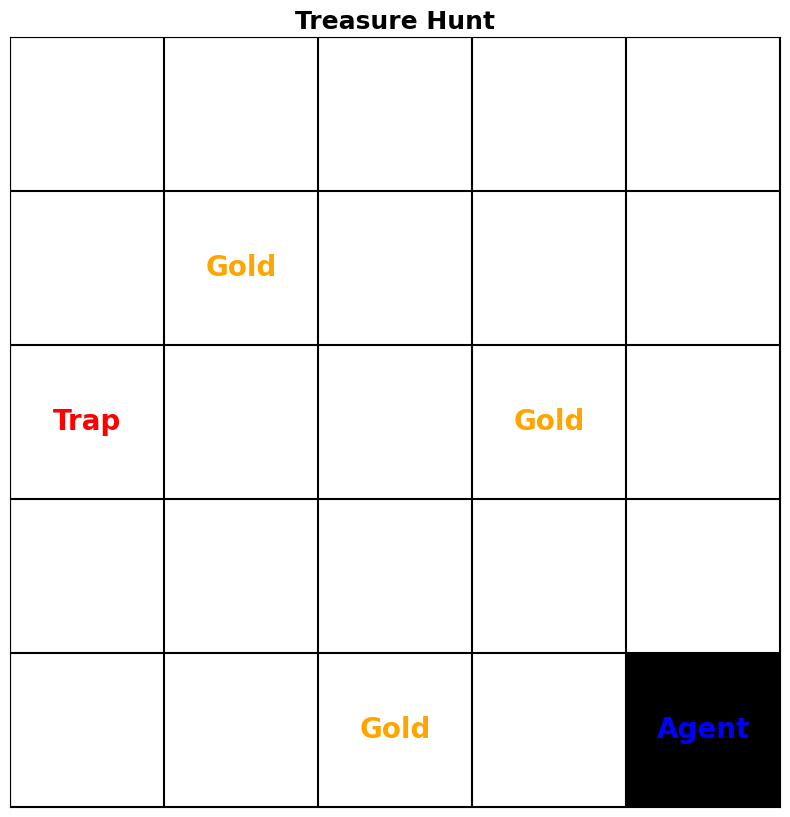

In [4]:
evaluation_episodes = 50
evaluation_rewards, evaluation_comments = agent.evaluate(evaluation_episodes)
env.render()

Trained Q1 Table:
(0, 0): {'Up': 0.0, 'Down': 3.107072402114988, 'Left': 0.0, 'Right': 0.0}
(0, 1): {'Up': 2.104972568656234, 'Down': 0, 'Left': 0.0, 'Right': 3.33115252976545}
(0, 2): {'Up': 0.20473238470842614, 'Down': 0.14669543070000002, 'Left': 0.0, 'Right': 5.56741137790759}
(0, 3): {'Up': 0.3002634153307082, 'Down': 7.271699893447444, 'Left': 2.1156254765095337, 'Right': 2.6669437068611654}
(0, 4): {'Up': 0.0, 'Down': 0.0, 'Left': 4.72398589070632, 'Right': 0.0}
(1, 0): {'Up': 0.126, 'Down': 0, 'Left': -0.39563451899999996, 'Right': 4.253685921088117}
(1, 1): {'Up': 2.7419725686562346, 'Down': 4.080052470099117, 'Left': 1.7450550784154442, 'Right': 6.963216543538243}
(1, 2): {'Up': 3.5482754887763357, 'Down': 0, 'Left': 5.167835602420095, 'Right': 8.301792591788875}
(1, 3): {'Up': 4.620927938882442, 'Down': 7.6870470076055675, 'Left': 4.246898255758003, 'Right': 11.321750511884531}
(1, 4): {'Up': 2.9457306994694803, 'Down': 15.690577125374846, 'Left': 6.737955954789586, 'Right':

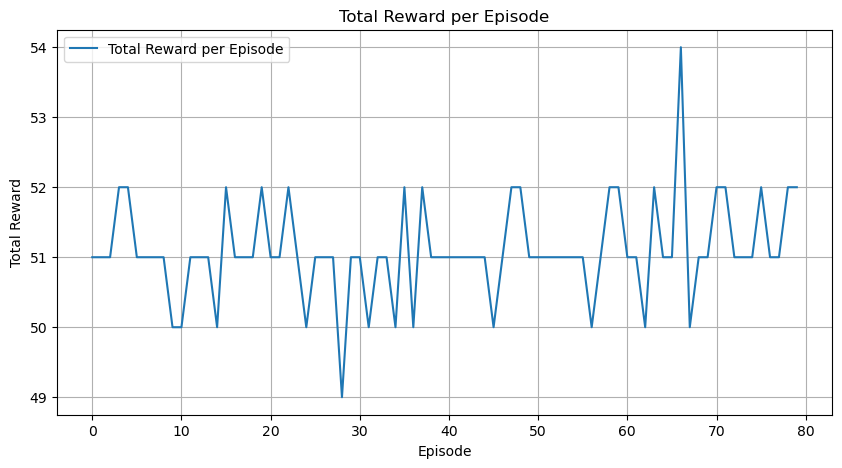

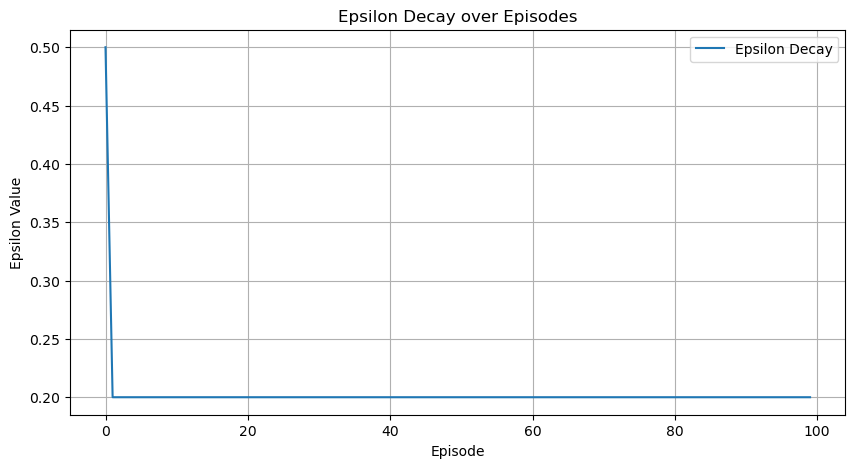

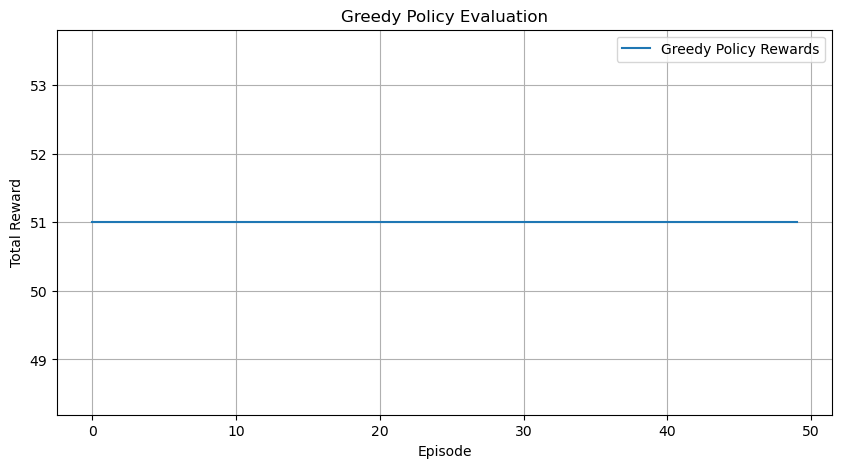

In [5]:
print("Trained Q1 Table:")
for state, actions in agent.Q1.items():
    print(f"{state}: {actions}")

print("\nTrained Q2 Table:")
for state, actions in agent.Q2.items():
    print(f"{state}: {actions}")

plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode[20:], label="Total Reward per Episode")
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epsilon_values, label="Epsilon Decay")
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay over Episodes')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(evaluation_rewards, label="Greedy Policy Rewards")
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Greedy Policy Evaluation')
plt.legend()
plt.grid()
plt.show()


# Refrences: 

https://www.restack.io/p/reinforcement-learning-answer-gridworld-example-python-cat-ai

https://ubuffalo-my.sharepoint.com/personal/avereshc_buffalo_edu/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Favereshc%5Fbuffalo%5Fedu%2FDocuments%2F2024%5FFall%5FRL%2F%5Fpublic%2FCourse%20Materials%2FRL%20Environment%20Demo

https://www.supplychaindataanalytics.com/visualizing-2d-grids-and-arrays-using-matplotlib-in-python/

https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html

https://www.geeksforgeeks.org/matplotlib-pyplot-gca-in-python/
https://www.geeksforgeeks.org/sarsa-reinforcement-learning/

https://www.datacamp.com/tutorial/sarsa-reinforcement-learning-algorithm-in-python

https://advancedoracademy.medium.com/what-is-sarsa-an-introduction-8f495daf2418

https://www.youtube.com/watch?v=FhSaHuC0u2M&t=1s

https://builtin.com/machine-learning/sarsa

https://rubikscode.net/2020/01/20/double-q-learning-python/

https://www.kaggle.com/code/nitramj/double-q-learning-implementation

https://www.youtube.com/watch?v=XD0g2iBC80k

https://arxiv.org/abs/2407.02369

https://stackoverflow.com/questions/49822078/why-is-there-no-n-step-q-learning-algorithm-in-suttons-rl-book

http://incompleteideas.net/book/the-book-2nd.html
